#Boston Dataset


    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per $10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000's


##Importar Data

In [0]:
import pandas as pd

In [250]:
df = pd.read_csv("Boston.csv")
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [0]:
del df['Unnamed: 0']

##Boxplot

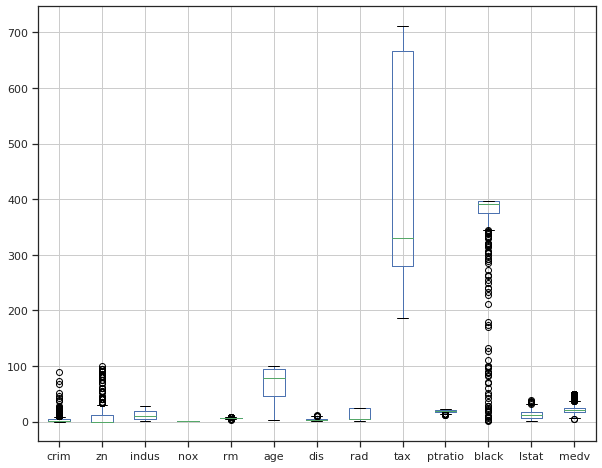

In [252]:
df.drop("chas",axis=1).boxplot(figsize=(10,8))

##Eliminar Outliers

###RIQ

In [253]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

crim         3.595037
zn          12.500000
indus       12.910000
chas         0.000000
nox          0.175000
rm           0.738000
age         49.050000
dis          3.088250
rad         20.000000
tax        387.000000
ptratio      2.800000
black       20.847500
lstat       10.005000
medv         7.975000
dtype: float64


In [0]:
df_modificado = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [256]:
df.shape

(506, 14)

In [255]:
df_modificado.shape

(268, 14)

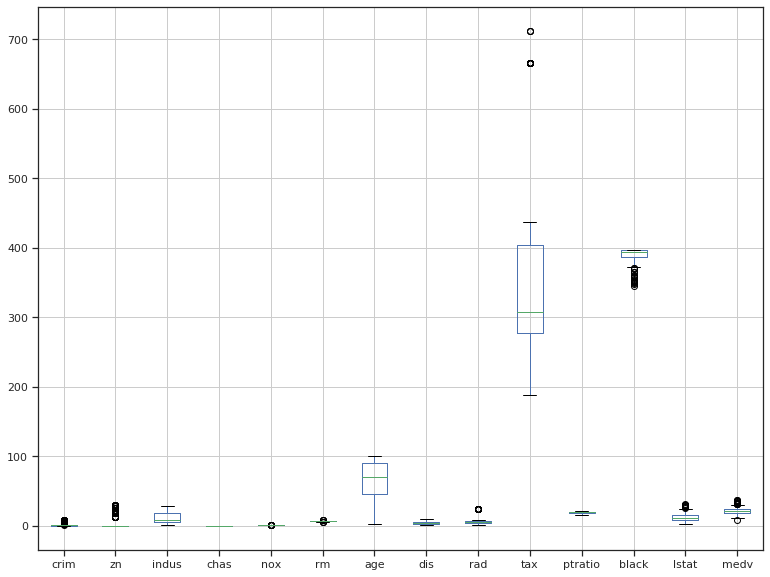

In [257]:
df_modificado.boxplot(figsize=(13,10))

###Z-Score

In [0]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df))

In [0]:
df_z = df[(z < 3).all(axis=1)]

In [264]:
df_z.shape

(415, 14)

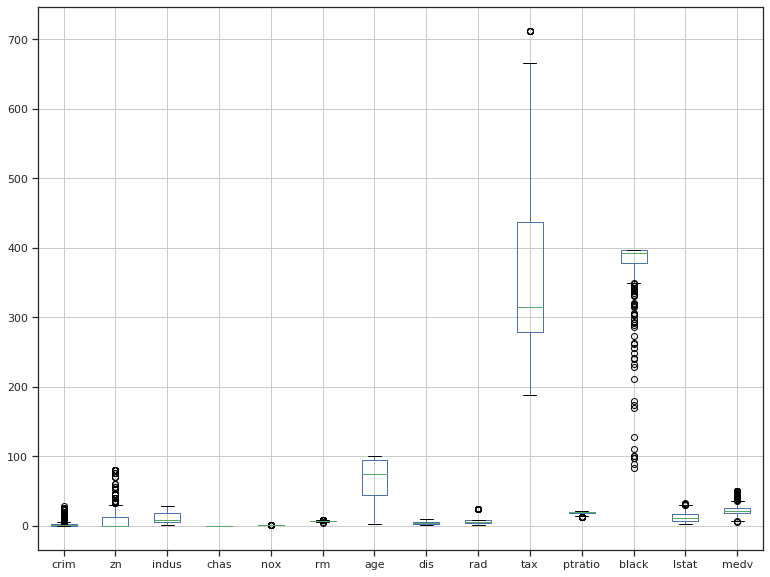

In [265]:
df_z.boxplot(figsize=(13,10))

###Separar Data

In [0]:
X = df_z.drop('medv',axis = 1)
y = df_z['medv']

In [318]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state = 2)
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)

X_train shape: (332, 13)
X_test shape: (83, 13)


###Estandarizar

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

###Regresión Lineal

In [320]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [239]:
reg.coef_

array([-1.05618627e-01,  4.91381113e-02,  3.21540897e-02,  2.51293737e+00,
       -1.76280019e+01,  3.81765978e+00,  1.05792271e-02, -1.43608998e+00,
        3.61498721e-01, -1.54712068e-02, -9.12347239e-01,  9.85932090e-03,
       -5.55092176e-01])

In [321]:
reg.score(X_train,y_train)

0.7210190987210665

In [322]:
reg.score(X_test,y_test)

0.797151413402452

###Regresión KNN

In [347]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3,weights='distance',metric='manhattan')
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='distance')

In [348]:
neigh.score(X_test,y_test)

0.7558046792869595

In [0]:
max_depth_range = list(range(2, 15))
accuracy_KNN = []
for depth in max_depth_range:
    neigh = KNeighborsRegressor(n_neighbors=depth,weights='distance',metric='cosine') #Cambiar aquí
    neigh.fit(X_train, y_train)  
    score = neigh.score(X_test, y_test)
    
    accuracy_KNN.append(score)

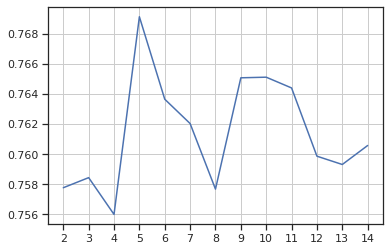

In [346]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(accuracy_KNN)
plt.xticks(list(range(len(max_depth_range))),max_depth_range)
plt.grid()
plt.show()

uniform -> 0.77 k = 3

euclidean -> 0.775 k= 3

manhattan -> 0.776 k = 3

##Cross validation

In [352]:
from sklearn.model_selection import KFold
from sklearn import metrics
NSplits = 20
kf = KFold(n_splits=NSplits)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=20, random_state=None, shuffle=False)


In [353]:
AccTotal = 0
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
  
  reg = LinearRegression()
  reg.fit(X_train_cv,y_train_cv)

  AccFolder = reg.score(X_test_cv, y_test_cv)*100
  print("Accuracy Folder", AccFolder)
  
  AccTotal += AccFolder
  
print("Accuracy General:", AccTotal/NSplits)

Accuracy Folder 65.8657093617957
Accuracy Folder 89.17714811274385
Accuracy Folder 31.1320051831211
Accuracy Folder 35.949790999945584
Accuracy Folder 68.77034011846015
Accuracy Folder -8.314166687529955
Accuracy Folder -68.4080359278806
Accuracy Folder 67.01502031451679
Accuracy Folder 33.68626307906348
Accuracy Folder 64.08583595524482
Accuracy Folder 65.5634850981842
Accuracy Folder 83.17831815759385
Accuracy Folder 60.594851562107976
Accuracy Folder 14.230336133214184
Accuracy Folder -53.069217700863106
Accuracy Folder -142.1070799459801
Accuracy Folder -1.0268015037039557
Accuracy Folder -38.36198271555718
Accuracy Folder 67.55208896272029
Accuracy Folder 21.16288230700527
Accuracy General: 22.83383954321011


##Graficando

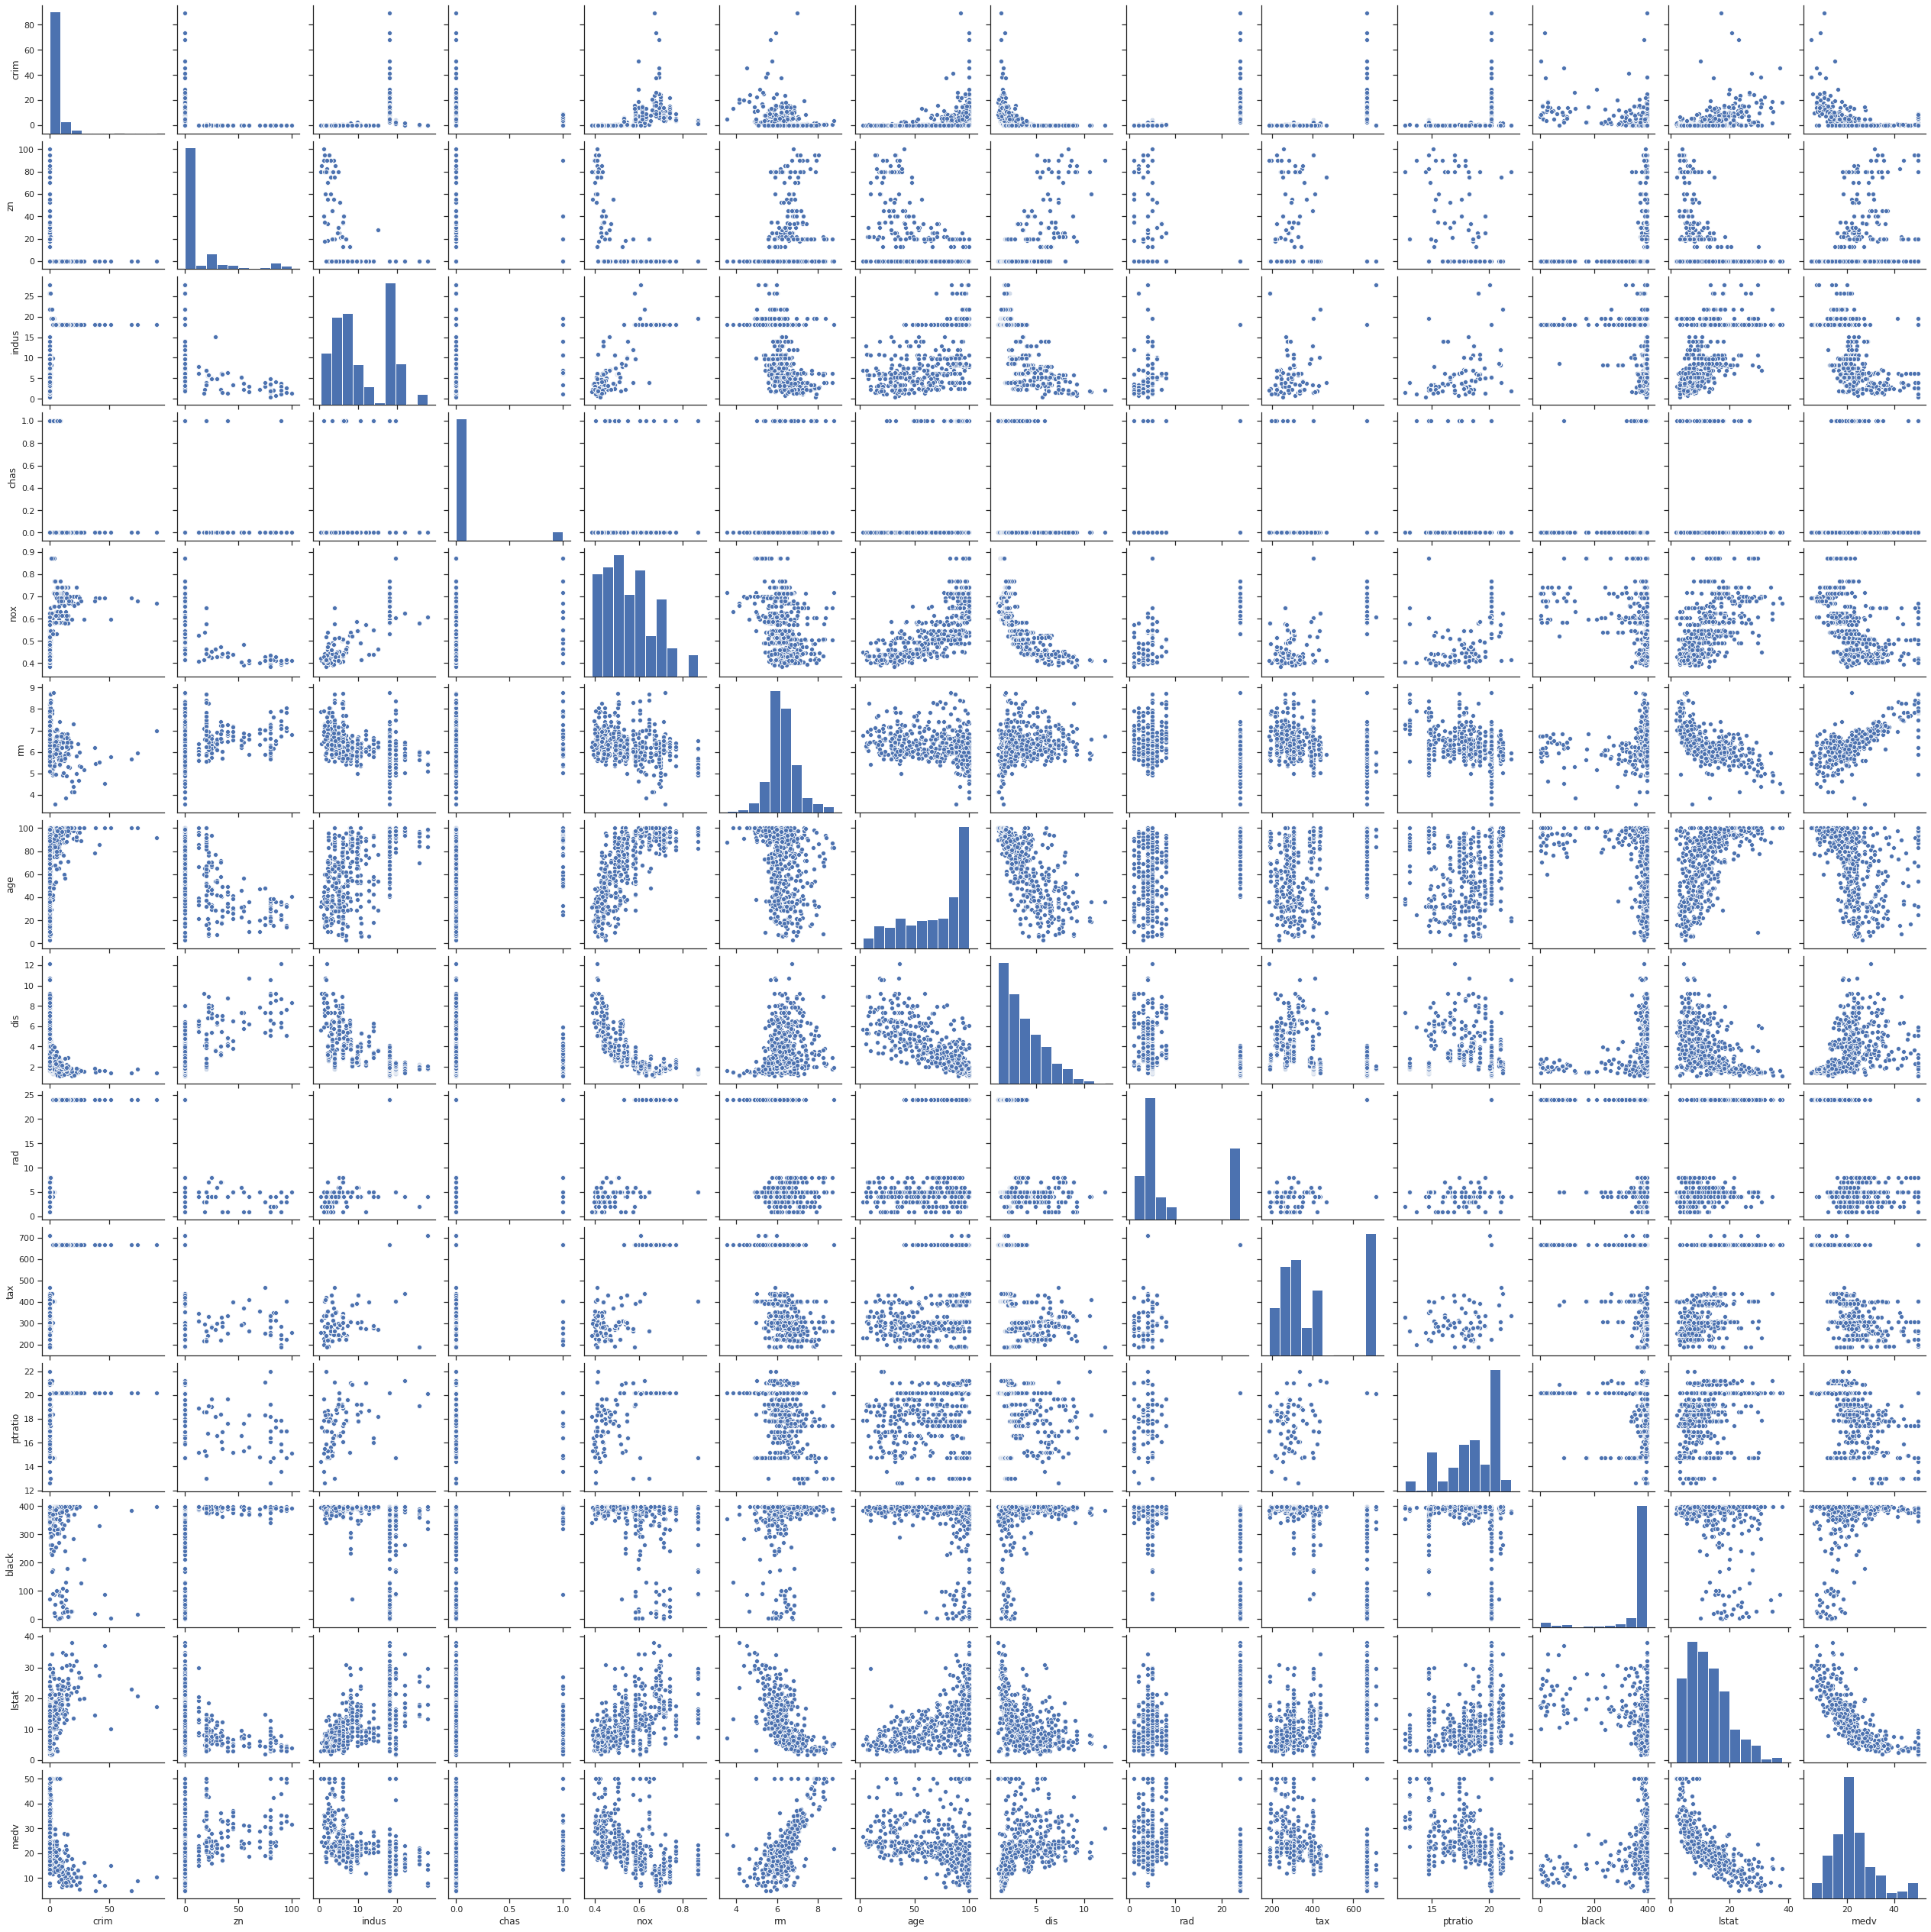

In [354]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df)
g.savefig("output.png")